In [1]:
import os
import numpy as np
import pickle
import dimod
import neal
import dwave_token
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time

from dwave.system import DWaveSampler, EmbeddingComposite, FixedEmbeddingComposite
from dwave.system import DWaveCliqueSampler
from dwave.system import LeapHybridCQMSampler

# automatically generated embedding:
sampler = EmbeddingComposite(DWaveSampler(token=dwave_token.value))
clique_sampler = DWaveCliqueSampler(token=dwave_token.value)
hybrid_sampler = LeapHybridCQMSampler(token=dwave_token.value)
simulated_sampler = neal.SimulatedAnnealingSampler()

Matplotlib created a temporary cache directory at /tmp/matplotlib-nwbqdndz because the default path (/home/user/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [17]:
def csv_to_matrix(file_name):
    dimension = len(np.genfromtxt(file_name)) - 1
    rows = np.array([element[0] for element in pd.read_csv(file_name, delimiter=';', usecols=[0]).to_numpy()])
    matrix = np.genfromtxt(file_name, delimiter=';', skip_header=1, usecols = range(1,dimension+1))
    return(rows, matrix)

def make_QUBO_upper_triangle(Q):
    Q = np.array(Q)
    return(np.transpose(Q - np.triu(Q)) + np.triu(Q))

def cyclic_permutate_array(arr,n):
    return(arr[len(arr)-n:] + arr[:len(arr)-n])
def distance_from_2Dpoints(points):
    n = len(points)
    d = np.zeros((n,n))
    for i in range(n):
        for j in range(i,n):
            d[i,j] = np.sqrt((points[i][0] - points[j][0])**2 + (points[i][1] - points[j][1])**2)
    return(d)

def make_QUBO_upper_triangle(Q):
    Q = np.array(Q)
    return(np.transpose(Q - np.triu(Q)) + np.triu(Q))

def weighted_clustering_heuristic(distances, k, delta, n_max, solver='DWAVE', time_limit=0, shots=100, penalty=False, fix_variables=False, printornot=True, sort_samples=None):
    N = len(distances)
    def obj_0(values,g):
        return(sum(distances[i,j] * values[i,g] * values[j,g] for i in range(N) for j in range(i,N)))
    def N_cluster(values,g):
        N_g = sum(values[i,g] for i in range(N))
        return(N_g * (N_g-1))
    def obj(values):
        return(sum(obj_0(values,g)/N_cluster(values,g) if sum(values[i,g] for i in range(N)) > 1 else 0 for g in range(k)))
    def check_feasibility(values):
        return(np.array([sum(values[i,g] for g in range(k)) for i in range(N)]) == 1)
    def sampleset_to_values(sampleset, sort=None):
        if sort == 'lambda':
            prevalues_list = [dict(sampleset.samples()[i]) for i in range(len(sampleset))]
            if fix_variables:
                values_list = [{(i,g): int(g==0) if i == 0 else int(round(prevalues[g*N+i],0)) for g in range(k) for i in range(0,N)} for prevalues in prevalues_list]
            else:
                values_list = [{(i,g): int(round(pre_values[g*N+i],0)) for g in range(k) for i in range(N)} for prevalues in prevalues_list]
            lambda_list = [obj(values) for values in values_list]
            min_position = np.argmin(lambda_list)
            values = values_list[min_position]
        else:
            pre_values = dict(sampleset.lowest().samples()[0])
            if fix_variables:
                values = {(i,g): int(g==0) if i == 0 else int(round(pre_values[g*N+i],0)) for g in range(k) for i in range(0,N)}
            else:
                values = {(i,g): int(round(pre_values[g*N+i],0)) for g in range(k) for i in range(N)}
        return(values)
    if penalty == False and (solver != 'hybrid' and solver != 'CPLEX'):
        penalty = True
    if penalty == True:
        penalty = N*[np.max(distances)* (N - k)]
    elif (isinstance(penalty, int) or isinstance(penalty, float)):
        penalty = N*[penalty]
    elif penalty == 'vector':
        penalty = list(np.sum(distances,1)/np.sum(distances))  
    if solver == 'CPLEX':
        model = pyo.AbstractModel()
        model.points = pyo.RangeSet(0, N-1)
        model.unique_pairs = pyo.Set(initialize=model.points*model.points, filter = lambda model, p1, p2: p1 < p2)
        model.clusters = pyo.RangeSet(0,k-1)
        model.d = pyo.Param(model.unique_pairs, initialize=lambda model, p1, p2: distances[p1,p2])
        model.lambda_n = pyo.Param(default=0, within=pyo.NonNegativeReals)
        model.x = pyo.Var(model.points*model.clusters, within=pyo.Binary)
        def obj_0_pyomo(model,g):
            return(sum(model.d[i,j]*model.x[i,g]*model.x[j,g] for i,j in model.unique_pairs))
        def N_cluster_pyomo(model,g):
            N_g = sum(model.x[i,g] for i in model.points)
            return(N_g * (N_g-1))
        def uniqueness(model,i):
            return(sum(model.x[i,g] for g in model.clusters) == 1)
        if penalty:
            model.obj = pyo.Objective(rule=lambda model: sum(obj_0_pyomo(model,g) - model.lambda_n * N_cluster_pyomo(model,g) for g in model.clusters) + sum(penalty[i] * (sum(model.x[i,g] for g in model.clusters) - 1)**2 for i in model.points))
        else:
            model.obj = pyo.Objective(rule=lambda model: sum(obj_0_pyomo(model,g) - model.lambda_n * N_cluster_pyomo(model,g) for g in model.clusters))
            model.uniqueness = pyo.Constraint(model.points, rule=uniqueness)
        opt = pyo.SolverFactory('cplex', tee=False)
        if time_limit != 0:
            opt.options['timelimit'] = time_limit
    else:
        QUBO_core = np.triu([[distances[i,j] if g == l else 0 for g in range(k) for j in range(N)] for l in range(k) for i in range(N)])
        bqm_core = dimod.BinaryQuadraticModel.from_qubo(QUBO_core)
        if solver != 'hybrid':
            QUBO_penalty = make_QUBO_upper_triangle([[(-penalty[i] if g == l else penalty[i]) if i == j else 0 for g in range(k) for i in range(N)] for l in range(k) for j in range(N)])
            bqm_core.add_linear_from_array(np.diag(QUBO_penalty))
            bqm_core.add_quadratic_from_dense(QUBO_penalty - np.diag(np.diag(QUBO_penalty)))
            bqm_core.offset = np.sum(penalty)
        if solver == 'clique':
            DWavesampler = clique_sampler
        elif solver == 'SA':
            DWavesampler = simulated_sampler
        elif solver == 'hybrid':
            def uniqueness(i):
                return([g*N + i for g in range(k)])
        else:
            DWavesampler = sampler
    lambdas = [0]
    ## start loop:
    for n in range(n_max+1):
        if printornot:
            print('n = ', n)
        lambda_n = lambdas[-1]
        if solver == 'CPLEX':
            instance = model.create_instance(data={None: {'lambda_n': {None: lambda_n}}})
            if fix_variables:
                for g in model.clusters:
                    instance.x[0,g].fix(int(g==0))
            results = opt.solve(instance)
            values = {(i,g): int(round(pyo.value(instance.x[i,g]),0)) for g in range(k) for i in range(N)}
        else:
            QUBO_lambda = - lambda_n * make_QUBO_upper_triangle([[1 if (g == l and i != j) else 0 for g in range(k) for i in range(N)] for l in range(k) for j in range(N)])
            bqm = dimod.as_bqm(bqm_core, copy=True)
            bqm.add_linear_from_array(np.diag(QUBO_lambda))
            bqm.add_quadratic_from_dense(QUBO_lambda - np.diag(np.diag(QUBO_lambda)))
            if fix_variables:
                bqm.fix_variables({g*N:int(g==0) for g in range(k)})
            if solver == 'hybrid':
                cqm = dimod.ConstrainedQuadraticModel.from_bqm(bqm)
                for i in range(int(fix_variables), N):
                    cqm.add_discrete(uniqueness(i), label='uniqueness' + str(i))
                sampleset = hybrid_sampler.sample_cqm(
                    cqm,
                    time_limit = time_limit,
                )
            else:
                chain_strength = max(bqm.quadratic.values())
                sampleset = DWavesampler.sample(
                    bqm,
                    num_reads=shots,
                    chain_strength=chain_strength
                )
            sampleset.resolve() # to reduce output readout time (does not seem to work tbh)
            values= sampleset_to_values(sampleset, sort=sort_samples)
        # post processing:
        feasibility = check_feasibility(values)
        while (not all(feasibility)) and penalty:
            if printornot:
                print('Post Processing...')
            for i in [i for i in range(N) if not feasibility[i]]:
                one_hot_sum = sum(values[i,g] for g in range(k))
                if one_hot_sum == 0:
                    values[(i,0)] = 1
                else:
                    for l in [l for l in range(k) if values[i,l] == 1][1:]:
                        values[(i,l)] = 0
            if solver != 'CPLEX':
                sampleset_feasible = sampleset.filter(lambda sample: all(np.array([sum(sample.sample[g*N+i] for g in range(k)) == 1 for i in range(int(fix_variables),N)])))
                if len(sampleset_feasible) > 0:
                    values_feasible= sampleset_to_values(sampleset_feasible, sort=sort_samples)
                    if obj(values_feasible) < obj(values):
                        if printornot:
                            print('Best feasible solution better than standard post processing')
                        values = values_feasible
                    elif printornot:
                        print('Standard post processing better than best feasible solution')
            feasibility = check_feasibility(values)
        lambda_n1 = obj(values)
        if all(lambda_n1 < np.array(lambdas[1:])) or n == 0:
            clusters = [[i for i in range(N) if values[(i,g)] == 1] for g in range(k)]
        lambdas += [lambda_n1]
        if printornot:
            print('lambda = ',lambda_n1)
        if abs(lambda_n1 - lambdas[-2]) <= delta: # break loop if algorithm terminated
            break
        elif any(abs((lambda_n1 - np.array(lambdas[1:-2]))) <= delta): # or if it is in a loop
            print('Algorithm cought in a loop')
            break
        elif n == n_max:
            print('Algorithm did not terminate in ' + str(n_max) + ' steps.')
    return(lambdas, clusters)

def elbow(distances, k_min, k_max, step, delta, n_max, solver='DWAVE', time_limit=0, penalty=False, fix_variables=False):
    objectives = []
    for k in range(k_min, k_max+1, step):
        print('k = ', k)
        lambdas, clusters = weighted_clustering_heuristic(distances, k, delta, n_max, solver, time_limit, penalty, fix_variables, printornot=False)
        objectives += [min(lambdas[1:])]
    plt.plot(range(k_min, k_max+1, step), objectives)
    plt.xlabel('k')
    plt.ylabel('objective')
    plt.show()
    return(objectives)

def objective(distances, clusters):
    return(sum(sum(distances[i,j] for i in cluster for j in cluster if i<j)/(len(cluster)*(len(cluster)-1)) if len(cluster) > 1 else 0 for cluster in clusters))

def import_points(file_name):
    points = np.genfromtxt(file_name, delimiter = ',')
    return(points)

def plot_2Dclusters(points, clusters, save=False):
    k = len(clusters)
    colors = list(mcolors.TABLEAU_COLORS)[:k]
    for i, cluster in enumerate(clusters):
        plt.scatter([points[j,0] for j in cluster], [points[j,1] for j in cluster], color=colors[i])
    if save:
        plt.savefig(save, dpi=250)
    plt.show()

def distance_from_2Dpoints(points):
    n = len(points)
    d = np.zeros((n,n))
    for i in range(n):
        for j in range(i,n):
            d[i,j] = np.sqrt((points[i][0] - points[j][0])**2 + (points[i][1] - points[j][1])**2)
    return(d)


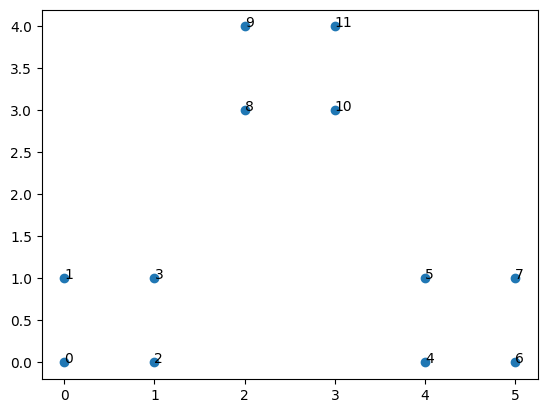

n =  0
lambda =  1.7071067811865475
n =  1
lambda =  2.366075116262454
n =  2
lambda =  1.53860669616091
n =  3
lambda =  2.0711087455889254
n =  4
lambda =  1.53860669616091
Algorithm cought in a loop
45.89117562233506
objective:  1.53860669616091
clusters: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], [], []]


In [16]:
points = [(0,0),(0,1),(1,0),(1,1),(4,0),(4,1),(5,0),(5,1),(2,3),(2,4),(3,3),(3,4)]
plt.scatter([x for x,y in points], [y for x,y in points])
for i, p in enumerate(points):
    plt.annotate(i, p)
plt.show()
distances = distance_from_2Dpoints(points)
lambdas, clusters = weighted_clustering_heuristic(distances, k=3, delta=0, n_max=10, solver='SA', time_limit=0, shots=1000, penalty=True, fix_variables=True, sort_samples='None')
print('objective: ', min(lambdas[1:]))
print('clusters:', clusters)
# plt.plot(lambdas)
# plt.show()

Comound data:

In [7]:
folder = 'Compound data/'
file_name = 'Matrix_chemphys_withdrawn_tanimoto_real_values.csv'
rows, distance_J = csv_to_matrix(os.path.join(folder,file_name))
N = 30
start = 35
distances = np.array([row[:N] for row in distance_J[:N]])
# distances = np.array([[d**2 for d in row] for row in distances]) #square distances

In [8]:
lambdas, clusters = weighted_clustering_heuristic(distances, k=5, delta=1e-5, n_max=10, solver='clique', time_limit=5, shots=100, penalty=True, fix_variables=True, sort_samples=None)
print('Best result: ', min(lambdas[1:]))
print(clusters)

n =  0
Post Processing...
lambda =  0.8143055555555556
n =  1
Post Processing...
lambda =  0.6314372294372294
n =  2
Post Processing...
lambda =  0.9798704212454212
n =  3
Post Processing...
lambda =  0.36369666666666656
n =  4
Post Processing...
lambda =  0.7389088827838829
n =  5
Post Processing...
lambda =  1.065892156862745
n =  6
Post Processing...
lambda =  0.1749629629629629
n =  7
Post Processing...
lambda =  0.709129761904762
n =  8
Post Processing...
lambda =  0.5668456140350878
n =  9
Post Processing...
lambda =  0.71484418767507
n =  10
Post Processing...
lambda =  0.7228824561403508
Algorithm did not terminate in 10 steps.
Best result:  0.1749629629629629
[[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], [13], [4], [], []]


Test data:

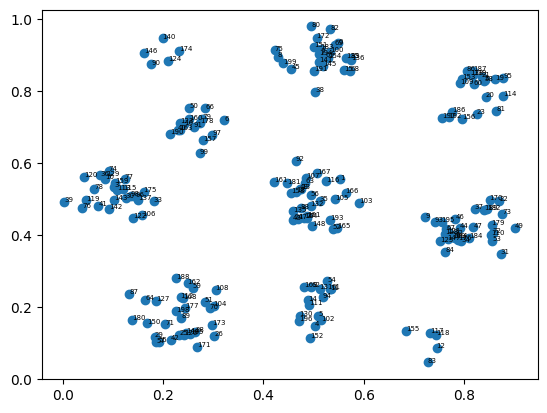

In [3]:
folder = 'Test_data'
file_name = 'uneven_dataset.txt'
points = import_points(os.path.join(folder,file_name))
plt.scatter([x for x,y in points], [y for x,y in points])
for i, p in enumerate(points):
    plt.annotate(i, p, size=5)
plt.show()

n =  0
lambda =  2.2240277946099716
n =  1
Post Processing...
lambda =  0.2290060103556321
n =  2
lambda =  2.192066587207576
n =  3
Post Processing...
Standard post processing better than best feasible solution
lambda =  0.2290060103556321
Algorithm cought in a loop
Best result:  0.2290060103556321
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 16

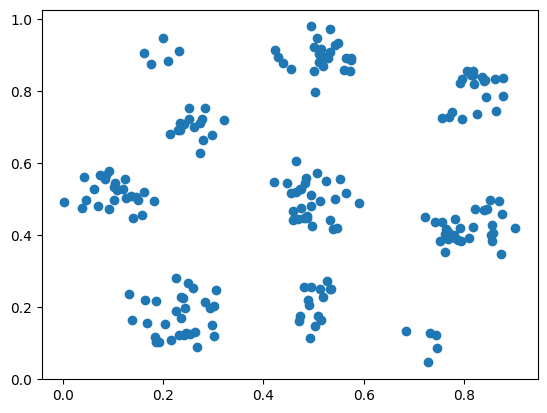

In [30]:
distances = distance_from_2Dpoints(points)
lambdas, clusters = weighted_clustering_heuristic(distances, k=10, delta=1e-6, n_max=10, solver='SA', time_limit=5, shots=1000, penalty=True, fix_variables=True, sort_samples=None)
print('Best result: ', min(lambdas[1:]))
print(clusters)
plot_2Dclusters(points, clusters, save='SA_uneven_highpenalty')

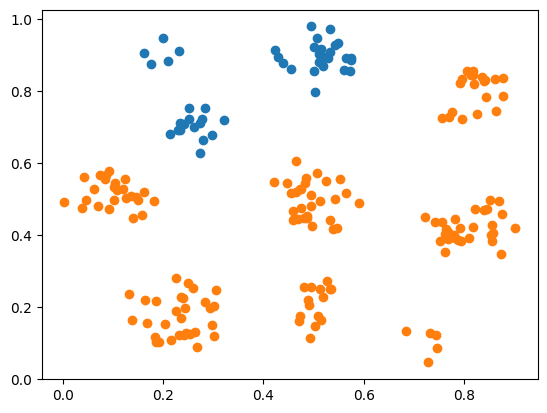

45


In [4]:
point_dict = dict(enumerate(points))
filter = [i for i, p in point_dict.items() if p[0] <= 0.6 and p[1] >= 0.78 or p[0] <=0.4 and p[1] >= 0.6]
antifilter = list(set(range(200)).difference(filter))
points_filtered = points[filter]
antifilter = list(set(range(200)).difference(filter))
point_dict_filtered = {i: p for i,p in point_dict.items() if i not in filter}
plt.scatter([x for x,y in points_filtered], [y for x,y in points_filtered])
plt.scatter([x for x,y in points[antifilter]], [y for x,y in points[antifilter]])
plt.show()
print(len(points_filtered))
distances = distance_from_2Dpoints(points_filtered)

n =  0
Post Processing...
lambda =  0.18115664063629355
n =  1
Post Processing...
lambda =  0.16770025040921083
n =  2
Post Processing...
lambda =  0.11052564623106559
n =  3
Post Processing...
lambda =  0.09591959641659877
n =  4
Post Processing...
lambda =  0.09591959641659877
Best result:  0.09591959641659877
[[0, 2, 3, 4, 6, 8, 10, 12, 13, 14, 16, 17, 18, 23, 26, 27, 29, 30, 32, 33, 37, 40, 42, 43, 44], [], [1, 5, 7, 9, 11, 15, 19, 20, 21, 22, 24, 25, 28, 31, 34, 35, 36, 38, 39, 41]]


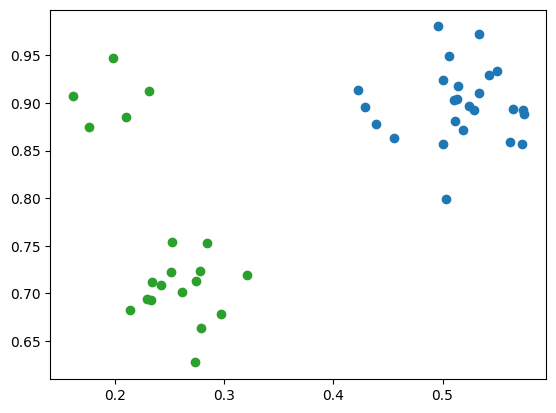

In [19]:
lambdas, clusters = weighted_clustering_heuristic(distances, k=3, delta=1e-6, n_max=10, solver='SA', time_limit=5, shots=1000, penalty=list(len(distances)*np.sum(distances,1)/np.sum(distances)), fix_variables=True, sort_samples=None)
print('Best result: ', min(lambdas[1:]))
print(clusters)
plot_2Dclusters(points_filtered, clusters, save=False)

In [20]:
list(len(distances)*np.sum(distances,1)/np.sum(distances))

[1.9540301277708019,
 1.862171814189952,
 1.6067499198161344,
 1.52483919613042,
 1.793160480466663,
 1.8704442926448854,
 1.6043673911742005,
 1.9150331261170326,
 1.3171849421037565,
 1.6160105192056518,
 1.3374429719959346,
 1.4598958860361115,
 1.506133203678872,
 1.387783976571806,
 1.1973082426621977,
 1.3192597412409643,
 1.35235368875079,
 1.393127780289097,
 1.3170823125235998,
 1.3437163984226987,
 1.1055295049056633,
 1.1246407594756065,
 1.3150544445590526,
 0.8602469439623931,
 1.0286309543070158,
 0.9827473975915634,
 0.7801924793874344,
 0.8104259499909369,
 0.9126464192879274,
 0.554693723513425,
 0.567429916308347,
 0.7860475612625624,
 0.4838151741333046,
 0.4923534567033267,
 0.45647003322615626,
 0.39610878621513224,
 0.42740356770258536,
 0.277484094556711,
 0.32290717444877615,
 0.2587967837786062,
 0.11864826179280928,
 0.21860425054332205,
 0.02449158572424603,
 0.01653476483151777,
 0.0]